In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from statsmodels.stats.power import TTestIndPower
import statsmodels


In [2]:
p = 0.05
pi0 = 0.5
beta = 0.8

minFPR = (p*pi0)/(p*pi0+(1-beta)*(1-pi0))
print(f'minimum FPR = {minFPR:.1f}')

minimum FPR = 0.2


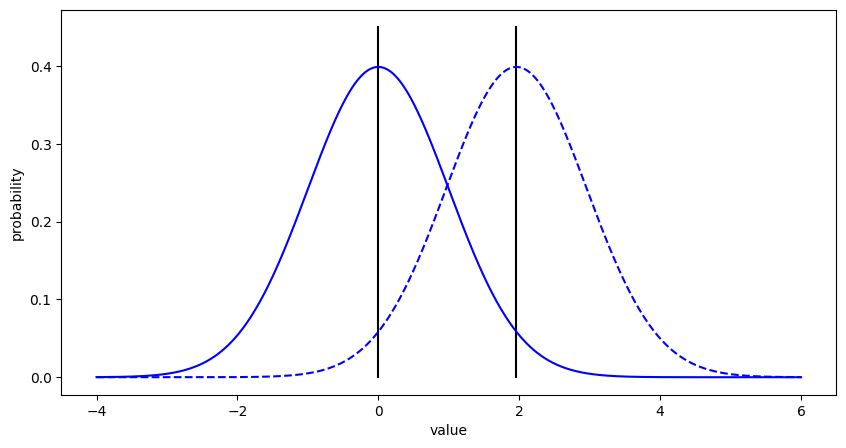

50172 positive outcomes out   of 100000 experiments (50.17 pct)


/var/folders/kb/51v8445d6ms9tg5p_zs_lnvr0000gp/T/ipykernel_8592/3721726903.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  normalizer          = np.trapz(counts_all, dx=bin_size)


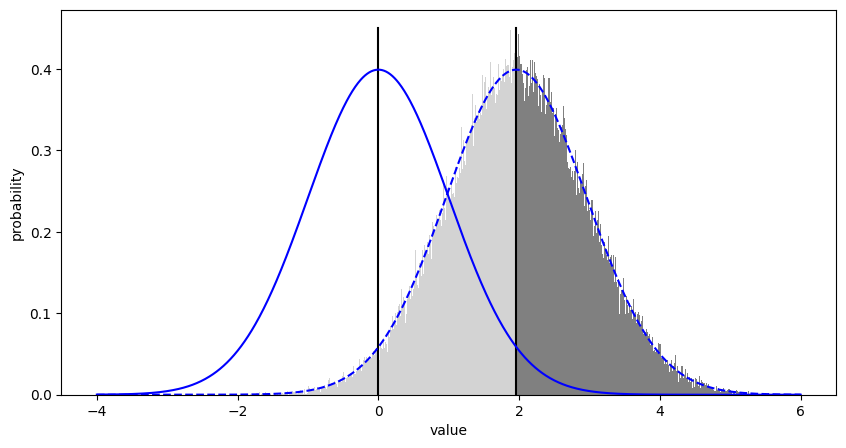

In [3]:
# Assume that an original study identified an effect size, 
#   representing the difference in the mean value of a test distribution 
#   versus a null distribution, divided by their common standard deviation 
#   (i.e., the z-score of their difference), at exactly p=0.05. Remember 
#   that these are distributions of mean values, so the standard deviations 
#   of these distributions represent standard errors of the mean. For a 
#   two-tailed test, this p-value implies that 0.975 of the area of the 
#   null distribtion is less than the effect size:
effect_size = st.norm.ppf(0.975)

# We can now reproduce the first panel:
plt.figure(figsize=(10, 5))
mu_0 = 0
sem = 1      # make it easy by assuming sem=1
mu_1 = effect_size*sem
bin_size = 0.01
x_axis = np.arange(-4, 6+bin_size, bin_size)
x_edges = np.arange(x_axis[0]-bin_size/2, x_axis[-1]+bin_size, bin_size)
plt.plot([mu_0, mu_0], [0, 0.45], 'k-')
plt.plot([mu_1, mu_1], [0, 0.45], 'k-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_0, sem), 'b-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_1, sem), 'b--')
plt.xlabel('value')
plt.ylabel('probability')
plt.show()

# Now what happens when we try to replicate the result under the exact 
#   same conditions? Let's simulate N experiments:
N = 100000

# In each simulated experiment, we end up with a mean value that comes 
#   from the experimental distribution, and we only reject the Null 
#   hypothesis if the value is greater than or equal to the previous effect size:
outcomes = np.random.normal(mu_1, sem, N)
outcome_is_positive = outcomes >= effect_size
print(f'{np.count_nonzero(outcome_is_positive)} positive outcomes out \
  of {N} experiments ({np.count_nonzero(outcome_is_positive)/N*100:.2f} pct)')

# We can plot these results as a normalized histogram
counts_no_effect, _ = np.histogram(outcomes[np.logical_not(outcome_is_positive)], bins=x_edges)
counts_effect, _    = np.histogram(outcomes[outcome_is_positive], bins=x_edges)
counts_all, _       = np.histogram(outcomes, bins=x_edges)
normalizer          = np.trapz(counts_all, dx=bin_size)

# Plot it
plt.figure(figsize=(10, 5))
plt.bar(x_axis, counts_no_effect/normalizer, width=0.01, color='lightgray')
plt.bar(x_axis, counts_effect/normalizer, width=0.01, color='gray')
plt.plot([mu_0, mu_0], [0, 0.45], 'k-')
plt.plot([mu_1, mu_1], [0, 0.45], 'k-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_0, sem), 'b-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_1, sem), 'b--')
plt.xlabel('value')
plt.ylabel('probability')
plt.show()

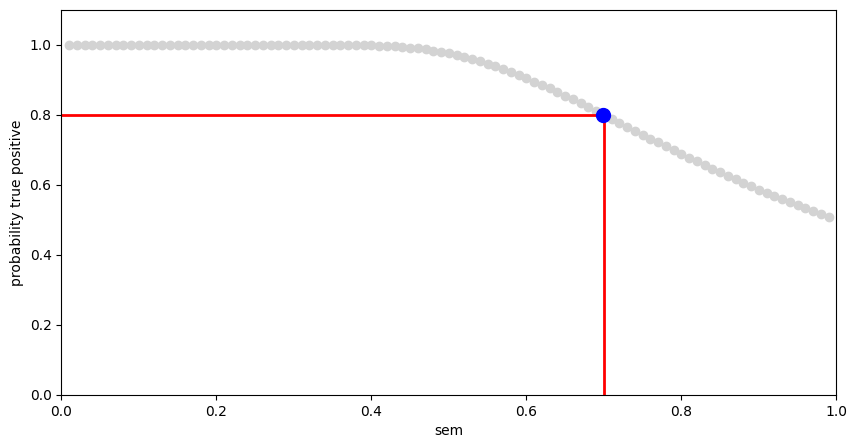

In [4]:

# We can increase the power by increasing the signal-to-noise ratio (SNR) of 
#   our sample, via a reduction in sem and assuming the same mean effect size. 
#   The figure in the paper is confusing, because increasing SNR would narrow 
#   *both* distributions (because we assume that the two hypotheses differ only 
#   by their mean value, not the STD of the distributions). It is the change in 
#   both distributions that explains why you would be less likely to reject the 
#   Null hypothesis for the same effect size under these conditions.
#
# Also note that sem depends on both the number of samples (N) and the STD of 
#   the sampled distribution, so we need to define N or STD to be able to 
#   express sem in terms of the other of those two values.

# We can use a power analysis to find the new sem. The key point is that a 
#   power analysis describes a relationship between the effect size and the 
#   power -- so we can define a particular power to compute the effect size. 
#   In this case, this computation is equivalent to doing a z test with one 
#   sample and a power of 80%, which can be computed as follows (which is 
#   basically computing: what is the mean of a standard normal distribution 
#   that has 80% of its mass >= the cutoff for the null distribution at z=0.975?)
power = 0.8
new_effect_size = st.norm.ppf(0.975) - st.norm.ppf(1-power)

# This effect size is again the z-score, given the same mean difference 
#   as above and the new sem -- so we can use it to compute the new sem:
old_effect_size = st.norm.ppf(0.975)
old_sem = 1
mu_0 = 0
mu_1 = effect_size*old_sem
new_sem = (mu_1-mu_0)/new_effect_size

# To show that this is the case, let's try a bunch of sems and find the 
#   value that corresponds to when 80% of the effect distribution is >= the 
#   p=0.05 cutoff for the null distribution

# Try a bunch of sems, smaller than before (i.e., <1)
sems = np.arange(0.01, 1, 0.01)
vals = np.zeros(np.size(sems))

# Loop through them
for idx, val in enumerate(sems):
   
   # The probability of not rejecting the null hypothesis when the null 
   #  hypothesis is false is the mass of the effect distribution, which still 
   #  has a mean value of effectSize but now has the given sem, that is to the 
   #  right of the new cutoff
   new_cutoff = st.norm.ppf(0.975, mu_0, val)
   vals[idx] = 1 - st.norm.cdf(new_cutoff, effect_size, val) 

# Plot it
plt.figure(figsize=(10, 5))
plt.plot(sems, vals, 'o', color='lightgray')
val_indices = np.flatnonzero(vals<=0.8)
new_sem2 = sems[val_indices[0]]
plt.plot([new_sem2, new_sem2], [0, 0.8], 'r-', linewidth=2)
plt.plot([0, new_sem2], [0.8, 0.8], 'r-', linewidth=2)
plt.plot(new_sem, 0.8, 'bo', markerfacecolor='b', markersize=10)
plt.xlabel('sem')
plt.ylabel('probability true positive')
plt.axis([0, 1, 0, 1.1])
plt.show()

79966 positive outcomes out of   100000 experiments (79.97 pct)


/var/folders/kb/51v8445d6ms9tg5p_zs_lnvr0000gp/T/ipykernel_8592/2303974697.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  normalizer          = np.trapz(counts_all, dx=bin_size)


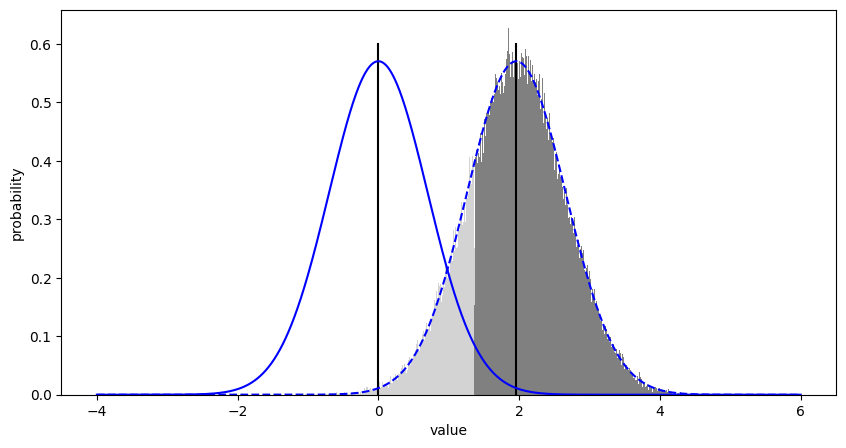

In [5]:
# Now do the simulated experiments as above, but with the new distributions
N = 100000
power = 0.8
new_effect_size = st.norm.ppf(0.975) - st.norm.ppf(1-power)
old_sem = 1
mu_0 = 0
mu_1 = effect_size*old_sem
new_sem = (mu_1-mu_0)/new_effect_size

bin_size = 0.01
x_axis = np.arange(-4, 6+bin_size, bin_size)
x_edges = np.arange(x_axis[0]-bin_size/2, x_axis[-1]+bin_size, bin_size)

outcomes = np.random.normal(mu_1, new_sem, N)
outcome_is_positive = outcomes >= st.norm.ppf(0.975, mu_0, new_sem)
print(f'{np.count_nonzero(outcome_is_positive)} positive outcomes out of \
  {N} experiments ({np.count_nonzero(outcome_is_positive)/N*100:.2f} pct)')

# We can plot these results as a normalized histogram
counts_no_effect, _ = np.histogram(outcomes[np.logical_not(outcome_is_positive)], bins=x_edges)
counts_effect, _    = np.histogram(outcomes[outcome_is_positive], bins=x_edges)
counts_all, _       = np.histogram(outcomes, bins=x_edges)
normalizer          = np.trapz(counts_all, dx=bin_size)

# Plot it
plt.figure(figsize=(10, 5))
plt.bar(x_axis, counts_no_effect/normalizer, width=0.01, color='lightgray')
plt.bar(x_axis, counts_effect/normalizer, width=0.01, color='gray')
plt.plot([mu_0, mu_0], [0, 0.6], 'k-')
plt.plot([mu_1, mu_1], [0, 0.6], 'k-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_0, new_sem), 'b-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_1, new_sem), 'b--')
plt.xlabel('value')
plt.ylabel('probability')
plt.show()


In [12]:
#Do a post-hoc power analysis to determine the number of data samples needed to achieve 80% power for a series of possible effect sizes. Notes and tips:
import numpy as np
from statsmodels.stats.power import TTestIndPower

# N = value we are solving for 

p = 0.05
alpha = 0.5
beta = 0.8
power = 0.8

new_effect_size = st.norm.ppf(0.975) - st.norm.ppf(1-power)
old_sem = 1
mu_0 = 0
mu_1 = effect_size*old_sem
new_sem = (mu_1-mu_0)/new_effect_size

# possible effect sizes
effect_sizes = [0.1, 0.5, 0.9]

# Initialize the power analysis object
analysis = TTestIndPower()

# Calculate the required sample sizes
sample_sizes = {}
for effect_size in effect_sizes:

# Compute sample size needed for each effect size
    required_n = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, alternative='two-sided')
    sample_sizes[effect_size] = np.ceil(required_n)  # Use ceiling to round up to the next whole number

# Print the results
print(f"Required sample sizes to achieve {power*100}% power:")
for effect_size, n in sample_sizes.items():
    print(f"Effect size {effect_size:.2f}: {int(n)} samples per group")


Required sample sizes to achieve 80.0% power:
Effect size 0.10: 426 samples per group
Effect size 0.50: 18 samples per group
Effect size 0.90: 6 samples per group
